# 丛集模式分析

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_cn = FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")
font_en = FontProperties(fname=r"C:\Windows\Fonts\times.ttf")


## 1.小时+工作日非工作日级别丛集模式的流量统计
  - （24h/工作日非工作日）统计丛集模式的总流量，刻画丛集模式的时间分布特征（上下两个柱状图比较）

In [41]:
def plot_cluster_flow_time_distribution_by_files(folder_path: str):
    """
    基于已分好时间切片的文件，统计丛集模式流量并绘制双柱状图
    （每个小时两根柱：左工作日，右非工作日）
    """

    # 初始化 24h × 2
    flow_workday = np.zeros(24)
    flow_nonworkday = np.zeros(24)

    # 文件名示例：od_flow_cluster_工作日_0.csv
    pattern = re.compile(r"_(工作日|非工作日)_(\d+)\.csv")

    for fname in os.listdir(folder_path):
        match = pattern.search(fname)
        if not match:
            continue

        day_type, hour = match.groups()
        hour = int(hour)

        df = pd.read_csv(os.path.join(folder_path, fname))

        # 只保留丛集模式流
        df = df[df["cluster_id"] != -1]

        # 该时间切片的丛集模式总流量
        flow_sum = df["flow_num"].sum()

        if day_type == "工作日":
            flow_workday[hour] += flow_sum
        else:
            flow_nonworkday[hour] += flow_sum

    # ---------- 绘图 ----------
    fig, ax = plt.subplots(figsize=(10, 4))

    x = np.arange(24)
    bar_width = 0.4

    ax.bar(
        x - bar_width / 2,
        flow_workday,
        width=bar_width,
        label="工作日"
    )
    ax.bar(
        x + bar_width / 2,
        flow_nonworkday,
        width=bar_width,
        label="非工作日"
    )
    
    ax.set_xticks(x)
    ax.set_xticklabels(
        [f"{h}-{h+1}" for h in x],
        rotation=45,
        ha="right"
    )
    # ax.set_xlabel("时间段（小时）")
    # ax.set_ylabel("丛集模式总流量")
    # ax.set_title("丛集模式共享单车流量的时间分布特征")
    ax.set_title(
        "丛集模式共享单车流量时间分布",
        fontproperties=font_cn
    )
    ax.set_xlabel(
        "时间段（小时）",
        fontproperties=font_cn
    )

    ax.set_ylabel(
        "丛集模式流量（次）",
        fontproperties=font_cn
    )

    ax.legend(
        prop=font_cn
    )
    plt.tight_layout()

    return fig, ax

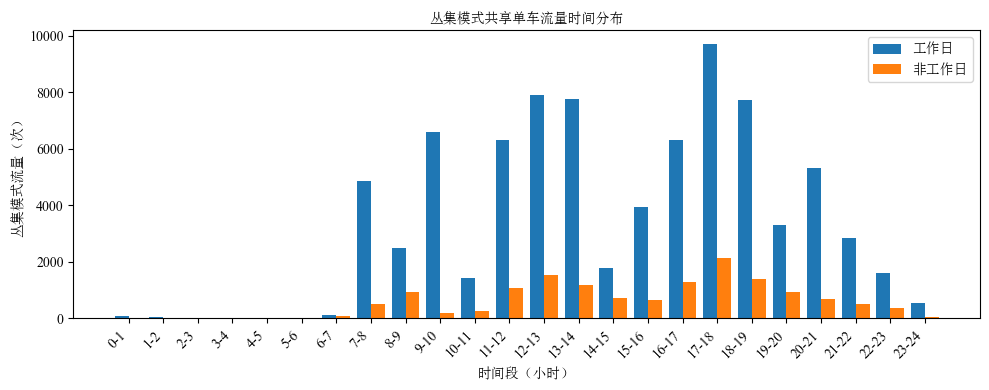

In [42]:
fig, ax = plot_cluster_flow_time_distribution_by_files(r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters")
fig.savefig("01_cluster_distributions.png", dpi=500)

## 2. 单时间段的流分析——流可视化（单线条，粗细代表流量大小）

### kepler可视化流图

In [55]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from keplergl import KeplerGl

def plot_top_flows_kepler(file_path: str, top_n: int = 20, lonlat_crs: str = "EPSG:4326", map_height: int = 700):
    """
    绘制流量前 top_n 的簇流可视化（KeplerGl），带线宽映射和流向箭头（arc）。
    
    参数
    ----
    file_path : str
        CSV 文件路径，必须包含列：
        ["cluster_id", "origin_lon", "origin_lat", "destination_lon", "destination_lat", "flow_num"]
    top_n : int
        只显示流量前 top_n 的簇
    lonlat_crs : str
        坐标参考系，默认 "EPSG:4326"
    map_height : int
        Kepler 地图高度，默认 700
    
    返回
    ----
    KeplerGl 对象
    """

    # 1. 读数据
    df = pd.read_csv(file_path)
    required_cols = ["cluster_id", "origin_lon", "origin_lat", "destination_lon", "destination_lat", "flow_num"]
    missing = set(required_cols) - set(df.columns)
    if missing:
        raise ValueError(f"缺少字段: {missing}")

    # 2. 聚合 cluster 层面
    cluster_flow = (
        df.groupby("cluster_id")
          .agg(
              ox=("origin_lon", "mean"),
              oy=("origin_lat", "mean"),
              dx=("destination_lon", "mean"),
              dy=("destination_lat", "mean"),
              flow=("flow_num", "sum")
          )
          .reset_index()
    )

    # 3. 只保留流量前 top_n
    cluster_flow = cluster_flow.nlargest(top_n, "flow")

    # 4. 构建 LineString
    cluster_flow["geometry"] = cluster_flow.apply(lambda r: LineString([(r.ox, r.oy), (r.dx, r.dy)]), axis=1)

    # 5. 转 GeoDataFrame
    gdf = gpd.GeoDataFrame(cluster_flow, geometry="geometry", crs=lonlat_crs)

    # 6. 创建 KeplerGl 地图
    center = {"latitude": 30.54, "longitude": 114.36, "zoom": 14}
    map_ = KeplerGl(
        height=map_height,
        config={
            "version": "v1",
            "config": {
                "mapStyle": {"styleType": "light"},
                "visState": {
                    "layers": [
                        {
                            "id": "cluster-flow-arc",
                            "type": "arc",
                            "config": {
                                "dataId": "cluster_flows",
                                "label": "Cluster Flow Arc",
                                "color": [180, 0, 0],
                                "columns": {
                                    "lat0": "oy",
                                    "lng0": "ox",
                                    "lat1": "dy",
                                    "lng1": "dx"
                                },
                                "isVisible": True,
                                "visConfig": {
                                    "thickness": 2,
                                    "sizeRange": [2, 60],  # 最大线宽加粗
                                    "strokeOpacity": 1
                                }
                            },
                            "visualChannels": {
                                "sizeField": {"name": "flow", "type": "integer"},
                                "sizeScale": "linear"  # 线性映射流量
                            }
                        }
                    ]
                },
                "mapState": {
                    "latitude": center["latitude"],
                    "longitude": center["longitude"],
                    "zoom": center["zoom"],
                    "bearing": 0,
                    "pitch": 0
                }
            }
        }
    )

    # 7. 加载数据
    map_.add_data(data=gdf, name="cluster_flows")
    return map_


In [56]:
map_ = plot_top_flows_kepler(
    r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters\od_flow_cluster_工作日_17.csv"
)
map_.save_to_html(
    file_name="01_cluster_visualization_工作日_17.html"
)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to 01_cluster_visualization_工作日_17.html!


### 单线条流图数据预处理（最后放置在qgis可视化）

In [42]:
import pandas as pd

def aggregate_cluster_flows_with_attrs(input_csv: str, output_csv: str):
    """
    将原始共享单车 OD 数据整理成簇流格式（起终点 + 流量总和 + 保留字段），用于 QGIS 可视化。
    
    参数
    ----
    input_csv : str
        原始 OD 数据 CSV 文件路径，必须包含 cluster_id 和 flow_num 字段
    output_csv : str
        输出 CSV 文件路径
    """
    
    # 1. 读取数据
    df = pd.read_csv(input_csv)
    
    required_cols = ["cluster_id","origin_lon","origin_lat","destination_lon","destination_lat","flow_num"]
    missing = set(required_cols) - set(df.columns)
    if missing:
        raise ValueError(f"缺少字段: {missing}")
    
    # 保留的其他字段
    extra_cols = [
        "distance_m","riding_time_s","is_workday",
        "origin_id","destination_id",
        "semantics_origin","semantics_dest",
        "semantics_id_origin","semantics_id_dest",
        "category_origin","category_dest",
        "category_id_origin","category_id_dest"
    ]
    
    # 2. 去掉噪声簇
    df = df[df["cluster_id"] != -1]
    
    # 3. 聚合簇流
    agg_dict = {
        "origin_lon":"mean",
        "origin_lat":"mean",
        "destination_lon":"mean",
        "destination_lat":"mean",
        "flow_num":"sum"
    }
    
    # 数值型字段取均值
    num_cols = ["distance_m","riding_time_s"]
    for c in num_cols:
        if c in df.columns:
            agg_dict[c] = "mean"
    
    # 分类/字符串型字段取最常见值
    cat_cols = [
        "is_workday","origin_id","destination_id",
        "semantics_origin","semantics_dest",
        "semantics_id_origin","semantics_id_dest",
        "category_origin","category_dest",
        "category_id_origin","category_id_dest"
    ]
    for c in cat_cols:
        if c in df.columns:
            agg_dict[c] = lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
    
    cluster_flow = df.groupby("cluster_id").agg(agg_dict).reset_index()
    
    # 4. 重命名列
    cluster_flow = cluster_flow.rename(columns={
        "origin_lon":"ox",
        "origin_lat":"oy",
        "destination_lon":"dx",
        "destination_lat":"dy",
        "flow_num":"flow"
    })
    
    # 5. 按 flow 降序排列
    cluster_flow = cluster_flow.sort_values(by="flow", ascending=False).reset_index(drop=True)
    
    # 6. 输出 CSV
    cluster_flow.to_csv(output_csv, index=False)
    print(f"已生成簇流 CSV: {output_csv}，共 {len(cluster_flow)} 条簇流记录")
    
    return cluster_flow


In [43]:
cluster_df = aggregate_cluster_flows_with_attrs(
    input_csv=r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters\od_flow_cluster_工作日_12.csv",
    output_csv=r"H:\code\shared_bike_pattern_mining\01_cluster_工作日_12_for_qgis.csv"
)


已生成簇流 CSV: H:\code\shared_bike_pattern_mining\01_cluster_工作日_12_for_qgis.csv，共 662 条簇流记录


## 3.丛集模式语义*语义流量矩阵绘制

In [34]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_category_flow_matrix(
    file_path: str,
    origin_col: str = "category_origin",
    dest_col: str = "category_dest",
    flow_col: str = "flow_num",
    figsize: tuple = (10, 8),
    cmap: str = "Blues"
):
    """
    绘制 category_origin → category_dest 的语义流量矩阵

    Parameters
    ----------
    file_path : str
        CSV 文件路径
    origin_col : str
        起点语义类别字段名
    dest_col : str
        终点语义类别字段名
    flow_col : str
        流量字段名（默认 flow_num）
    figsize : tuple
        图像尺寸
    cmap : str
        颜色映射（默认 Blues）

    Returns
    -------
    fig : matplotlib.figure.Figure
        生成的 Figure 对象
    """

    # 1. 读数据
    df = pd.read_csv(file_path)
    # 仅保留丛集模式流
    df = df[df["cluster_id"] != -1]

    # 2. 聚合 category → category 流量
    mat = (
        df.groupby([origin_col, dest_col])[flow_col]
          .sum()
          .reset_index()
          .pivot(index=origin_col, columns=dest_col, values=flow_col)
          .fillna(0)
    )

    # 3. 保证横纵类别顺序一致
    categories = sorted(set(mat.index) | set(mat.columns))
    mat = mat.reindex(index=categories, columns=categories, fill_value=0)

    print("CSV 行数:", len(df))
    print("flow_num 总和:", df[flow_col].sum())

    print(
        df.groupby([origin_col, dest_col])[flow_col]
        .sum()
        .sort_values(ascending=False)
        .head(12)
    )

    # 4. 绘图
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(mat.values, cmap=cmap)

    # 坐标轴
    ax.set_xticks(range(len(categories)))
    ax.set_yticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=45, ha="right",
                   fontproperties=font_cn)
    ax.set_yticklabels(categories,
                    fontproperties=font_cn)


    ax.set_title("工作日12-13h 丛集模式语义—语义流量矩阵", fontproperties=font_cn,fontsize=16)
    ax.set_xlabel("起点语义类别", fontproperties=font_cn,fontsize=14)
    ax.set_ylabel("终点语义类别", fontproperties=font_cn,fontsize=14)


    # 颜色条
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("总流量", fontproperties=font_cn,fontsize=14)

    fig.tight_layout()

    return fig

CSV 行数: 7906
flow_num 总和: 7906
category_origin  category_dest
学生宿舍             学生宿舍             1386
食堂               学生宿舍              660
学生宿舍             教学区域              658
教学区域             学生宿舍              635
学生宿舍             交通枢纽              588
交通枢纽             学生宿舍              459
教学区域             食堂                362
学生宿舍             食堂                279
食堂               教学区域              269
学生宿舍             其他                218
教学区域             交通枢纽              218
其他               学生宿舍              178
Name: flow_num, dtype: int64


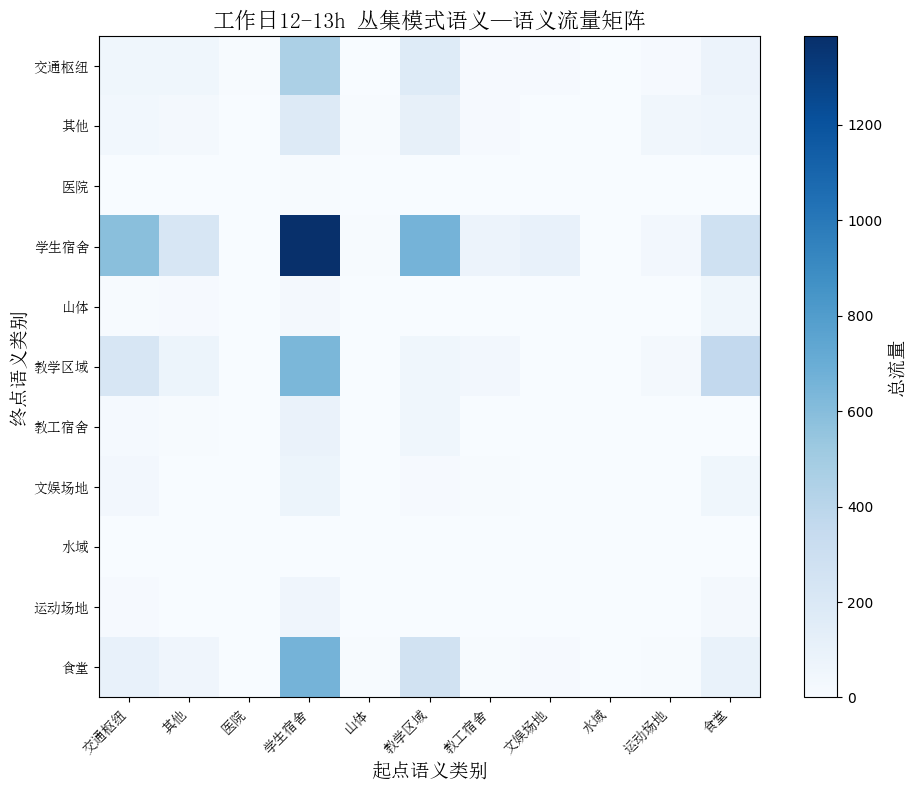

In [35]:
fig = plot_category_flow_matrix(r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters\od_flow_cluster_工作日_12.csv")
fig.savefig("01_category_flow_matrix_12.png", dpi=500)

## 4.CCDF图的绘制——找出典型丛集模式分布

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plot_cluster_flow_ccdf(
    file_path: str,
    cluster_col: str = "cluster_id",
    flow_col: str = "flow_num",
    noise_label: int = -1,
    figsize: tuple = (8, 6)
):
    """
    绘制丛集总流量的互补累计分布函数（CCDF）

    Parameters
    ----------
    file_path : str
        输入 CSV 文件路径
    cluster_col : str
        丛集 ID 字段名（默认 cluster_id）
    flow_col : str
        流量字段名（默认 flow_num）
    noise_label : int
        噪声簇标签（默认 -1）
    figsize : tuple
        图像大小

    Returns
    -------
    fig : matplotlib.figure.Figure
        CCDF 图的 Figure 对象
    """

    # 1. 读数据
    df = pd.read_csv(file_path)

    # 2. 去除噪声簇
    df = df[df[cluster_col] != noise_label]

    # 3. 计算每个簇的总流量
    cluster_flow = (
        df.groupby(cluster_col)[flow_col]
          .sum()
          .values
    )

    # 安全检查
    if len(cluster_flow) == 0:
        raise ValueError("去除噪声后没有有效的 cluster 数据")

    # 4. 计算 CCDF
    x = np.sort(cluster_flow)
    y = 1 - np.arange(1, len(x) + 1) / len(x)

    # 5. 绘图
    fig, ax = plt.subplots(figsize=figsize)

    ax.loglog(x, y, marker=".", linestyle="none")

    ax.set_xlabel("簇流量", fontproperties=font_cn,fontsize=14)
    ax.set_ylabel("P(X≥x)", fontproperties=font_en,fontsize=14)
    ax.set_title("工作日12-13h 丛集模式互补累计分布（CCDF）", fontproperties=font_cn,fontsize=16)

    ax.grid(True, which="both", linestyle="--", alpha=0.4)

    fig.tight_layout()

    return fig

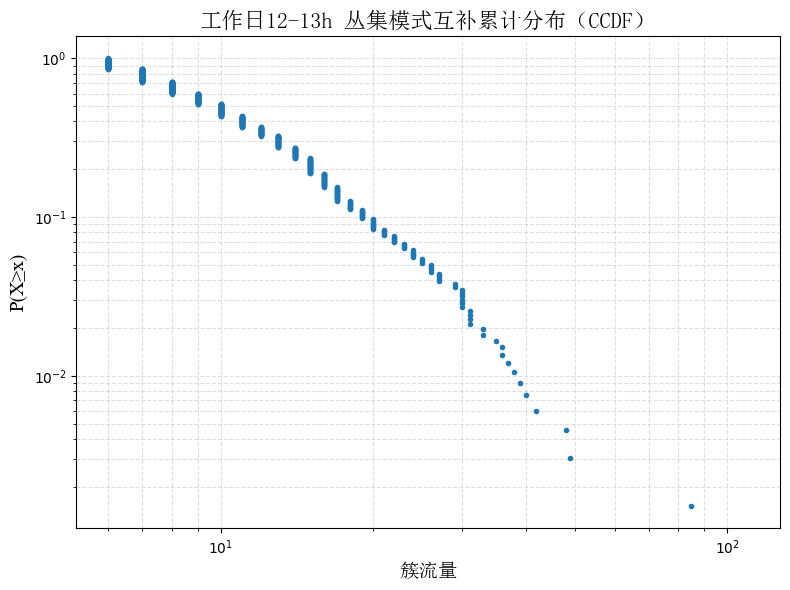

In [37]:
fig = plot_cluster_flow_ccdf(r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters\od_flow_cluster_工作日_12.csv")
fig.savefig("01_cluster_flow_ccdf_工作日_12.png", dpi=500)

## 5. topk簇语义分析（从哪里到哪里）——具体化的语义信息

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


def plot_cluster_semantic_bubble_matrix(
    file_path: str,
    top_k: int = 10,
    max_semantic_pairs: int = 20,
    figsize=(8, 4),
    min_bubble_size: int = 200,
    max_bubble_size: int = 2000,
):
    """
    气泡矩阵（单行版）：
    - y 轴：Top-K clusters（整体，仅一行）
    - x 轴：semantic → semantic（按全局流量降序）
    - 气泡大小：Top-K clusters 内的总 flow
    - 颜色：semantic-semantic 固定
    """

    # =====================
    # 1. 读数据 & 基础清洗
    # =====================
    df = pd.read_csv(file_path)
    df = df[df["cluster_id"] != -1]

    df["semantic_pair"] = (
        df["semantics_origin"].astype(str)
        + " → "
        + df["semantics_dest"].astype(str)
    )

    # =====================
    # 2. 选 Top-K 丛集（按总流量）
    # =====================
    cluster_total = (
        df.groupby("cluster_id")["flow_num"]
        .sum()
        .sort_values(ascending=False)
    )

    top_clusters = cluster_total.head(top_k).index.tolist()
    df = df[df["cluster_id"].isin(top_clusters)]

    # =====================
    # 3. 选 Top semantic–semantic
    # =====================
    semantic_total = (
        df.groupby("semantic_pair")["flow_num"]
        .sum()
        .sort_values(ascending=False)
    )

    semantic_order = semantic_total.head(max_semantic_pairs).index.tolist()
    df = df[df["semantic_pair"].isin(semantic_order)]

    # =====================
    # 4. 只在 semantic 维度聚合
    # =====================
    plot_df = (
        df.groupby("semantic_pair", as_index=False)["flow_num"]
        .sum()
    )

    plot_df["x"] = plot_df["semantic_pair"].map(
        {s: i for i, s in enumerate(semantic_order)}
    )
    plot_df["y"] = 0

    # =====================
    # 5. 气泡大小映射
    # =====================
    sizes = plot_df["flow_num"].values
    size_scaled = (
        min_bubble_size
        + (sizes - sizes.min())
        / (sizes.max() - sizes.min() + 1e-6)
        * (max_bubble_size - min_bubble_size)
    )

    # =====================
    # 6. 颜色
    # =====================
    cmap = plt.cm.get_cmap("tab20", len(semantic_order))
    color_map = {s: cmap(i) for i, s in enumerate(semantic_order)}
    colors = plot_df["semantic_pair"].map(color_map)

    # =====================
    # 7. 绘图
    # =====================
    fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(
        plot_df["x"],
        plot_df["y"],
        s=size_scaled,
        c=colors,
        alpha=0.85,
        edgecolors="white",
        linewidths=0.6
    )

    # =====================
    # ⭐ 7.5 在气泡上标注流量值（新增）
    # =====================
    for _, row in plot_df.iterrows():
        ax.text(
            row["x"],
            row["y"],
            f"{int(row['flow_num'])}",
            ha="center",
            va="center",
            fontsize=9,               # 字号：清晰但不抢
            color="black",
            fontproperties=font_cn,   # 宋体
            zorder=10                 # 保证在气泡之上
        )

    # =====================
    # 8. 坐标轴
    # =====================
    ax.set_xticks(range(len(semantic_order)))
    ax.set_xticklabels(
        semantic_order,
        rotation=45,
        ha="right",
        fontproperties=font_cn
    )

    ax.set_yticks([0])
    ax.set_yticklabels(
        [f"流簇流量"],
        fontproperties=font_cn
    )

    ax.set_xlim(-0.5, len(semantic_order) - 0.5)
    ax.set_ylim(-0.8, 0.8)

    ax.set_xlabel("起点语义-终点语义", fontproperties=font_cn)
    ax.set_title(
        f"工作日12-13h Top {top_k} 丛集模式语义-语义结构",
        fontproperties=font_cn
    )

    ax.grid(axis="x", linestyle="--", alpha=0.3)
    ax.set_axisbelow(True)

    fig.tight_layout()
    return fig


C:\Users\99776\AppData\Local\Temp\ipykernel_9600\3739930582.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(semantic_order))


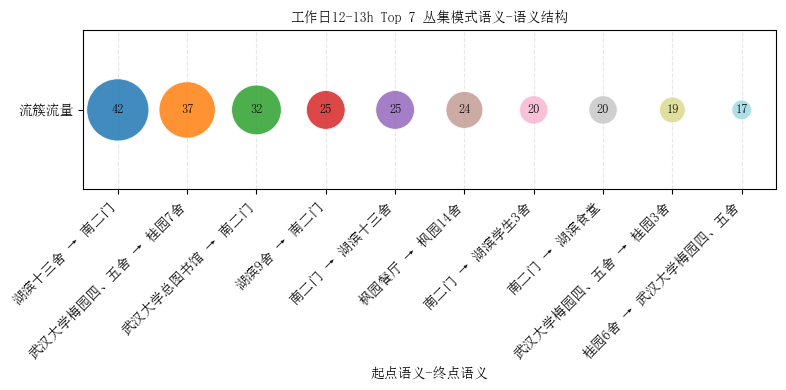

In [44]:
fig = plot_cluster_semantic_bubble_matrix(
    file_path=r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters\od_flow_cluster_工作日_12.csv",
    top_k=7,
    max_semantic_pairs=10
)

fig.savefig("01-cluster_semantic_bubble_matrix.png", dpi=500)


## 6.典型丛集模式的时序分析

In [91]:
OD_COLOR_LIST_50 = [
    # --- 原有主色（稳定区分） ---
    "#AEC7E8", "#FFBB78", "#98DF8A", "#FF9896", "#C5B0D5",
    "#C49C94", "#F7B6D2", "#1B9E77", "#DBDB8D", "#9EDAE5",

    "#6BAED6", "#FD8D3C", "#74C476", "#F16913", "#9E9AC8",
    "#8C6D31", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",

    "#80B1D3", "#FDB462", "#B3DE69", "#FB8072", "#BEBADA",
    "#FCCDE5", "#D9D9D9", "#FFFFB3", "#8DD3C7", "#CCEBC5",

    "#BC80BD", "#FFED6F", "#A6CEE3", "#B2DF8A", "#FB9A99",
    "#CAB2D6", "#FFFFCC", "#1F78B4", "#33A02C", "#E31A1C",

    "#66C2A5",  # 青绿
    "#FC8D62",  # 柔橙红
    "#8DA0CB",  # 冷紫蓝
    "#E5C494",  # 米棕
    "#FFD92F",  # 柔黄
    "#A6D854",  # 嫩绿
    "#E78AC3",  # 淡玫红
    "#B3B3B3",  # 中性灰
    "#1B9E77",  # 深青（少量对照）
    "#D95F02"   # 深橙（少量对照）
]


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from typing import Optional
from matplotlib.font_manager import FontProperties


def plot_top_od_stacked_bar_by_hour(
    folder_path: str,
    day_type: str = "工作日",
    start_hour: int = 7,
    end_hour: int = 23,
    top_pct: Optional[float] = None,   # 例如 0.01 表示 Top 1%
    top_n: Optional[int] = None,       # 例如 5 表示 Top 5
    max_od_labels: int = 12,           # 最多显示的 OD 语义数量
    figsize=(16, 7),
    font_cn: Optional[FontProperties] = None,
    font_en: Optional[FontProperties] = None
):
    """
    每个时间片内：
    1. 去除 cluster_id == -1
    2. 计算每个丛集模式的总流量（flow_num）
    3. 按丛集规模降序，选取 Top pct 或 Top N 的丛集（按数量比例）
    4. 统计这些丛集内【所有流】的 OD 语义流量
    5. 构建 时间 × OD 语义 的绝对流量矩阵
    6. 按全局 OD 总流量排序，并仅保留 Top K，其余合并为“其他”
    """

    # =====================
    # 参数检查
    # =====================
    if (top_pct is None and top_n is None) or (top_pct is not None and top_n is not None):
        raise ValueError("必须且只能指定 top_pct 或 top_n 其中一个")

    if top_pct is not None and not (0 <= top_pct <= 1):
        raise ValueError("top_pct 必须在 [0,1]，例如 0.01 表示 Top 1%")

    if top_n is not None and top_n <= 0:
        raise ValueError("top_n 必须是正整数")

    folder = Path(folder_path)
    files = [
        f for f in folder.glob("*.csv")
        if f"_{day_type}_" in f.name
    ]

    hour_pattern = re.compile(r"_(\d+)\.csv$")
    hourly_data = {}

    # =====================
    # 按小时处理
    # =====================
    for f in files:
        m = hour_pattern.search(f.name)
        if not m:
            continue

        hour = int(m.group(1))
        if hour < start_hour or hour > end_hour:
            continue

        df = pd.read_csv(f)
        df = df[df["cluster_id"] != -1]
        if df.empty:
            continue

        # 1️⃣ 丛集总流量
        cluster_flow = (
            df.groupby("cluster_id")["flow_num"]
              .sum()
              .sort_values(ascending=False)
        )

        if cluster_flow.empty:
            continue

        # 2️⃣ 选 Top 丛集（按数量）
        if top_pct is not None:
            k = max(1, int(np.ceil(len(cluster_flow) * top_pct)))
            top_clusters = cluster_flow.head(k).index
            top_desc = f"Top {int(top_pct * 100)}%"
        else:
            top_clusters = cluster_flow.head(top_n).index
            top_desc = f"Top {top_n}"

        df_top = df[df["cluster_id"].isin(top_clusters)].copy()
        if df_top.empty:
            continue

        # 3️⃣ OD 语义（统计的是丛集中【所有流】）
        df_top["od_category"] = (
            df_top["category_origin"].astype(str)
            + "→"
            + df_top["category_dest"].astype(str)
        )

        od_flow = df_top.groupby("od_category")["flow_num"].sum()
        hourly_data[hour] = od_flow

    if not hourly_data:
        raise ValueError("指定时间范围内无有效数据")

    # =====================
    # 构建 hour × OD 矩阵
    # =====================
    mat = pd.DataFrame(hourly_data).fillna(0).T
    mat = mat.sort_index()

    # =====================
    # ⭐ 全局 OD 语义排序 + 可选优化1
    # =====================
    od_global_sum = mat.sum(axis=0).sort_values(ascending=False)

    has_other = False

    if len(od_global_sum) > max_od_labels:
        main_ods = od_global_sum.head(max_od_labels).index
        other_ods = od_global_sum.index[max_od_labels:]

        mat_main = mat[main_ods].copy()
        mat_main["其他"] = mat[other_ods].sum(axis=1)
        mat = mat_main

        has_other = True

    # —— 只对“非其他”排序
    od_cols = [c for c in mat.columns if c != "其他"]
    od_sorted = mat[od_cols].sum(axis=0).sort_values(ascending=False).index.tolist()

    if has_other:
        od_sorted.append("其他")  # 强制放最后

    mat = mat[od_sorted]
    od_global_sum = mat.sum(axis=0)


    # =====================
    # 绘图
    # =====================
    fig, ax = plt.subplots(figsize=figsize)
    bottom = np.zeros(len(mat))

    # =====================
    # 固定离散配色（不重复）
    # =====================
    if len(mat.columns) > len(OD_COLOR_LIST_50):
        raise ValueError(
            f"OD 类别数 {len(mat.columns)} 超过可用颜色数 {len(OD_COLOR_LIST_50)}，"
            "请调大 max_od_labels 或合并为“其他”"
        )

    # colors = OD_COLOR_LIST_50[:len(mat.columns)]

    # =====================
    # 固定离散配色（“其他”不参与）
    # =====================
    OTHER_COLOR = "#BFBFBF"  # 中性灰

    od_cols = [c for c in mat.columns if c != "其他"]

    if len(od_cols) > len(OD_COLOR_LIST_50):
        raise ValueError(
            f"OD 类别数 {len(od_cols)} 超过可用颜色数 {len(OD_COLOR_LIST_50)}"
        )

    # 只给真实 OD 语义分配颜色
    od_color_map = {
        od: OD_COLOR_LIST_50[i]
        for i, od in enumerate(od_cols)
    }

    for od in mat.columns:
        color = OTHER_COLOR if od == "其他" else od_color_map[od]

        ax.bar(
            mat.index,
            mat[od].values,
            bottom=bottom,
            color=color,
            label=od
        )
        bottom += mat[od].values


    # x 轴：7–8 这种形式
    xticks = mat.index.tolist()
    xtick_labels = [f"{h}-{h+1}" for h in xticks]

    ax.set_xticks(xticks)
    ax.set_xticklabels(
        xtick_labels,
        rotation=45,
        ha="right",
        fontproperties=font_en
    )

    ax.set_xlabel("时间段（小时）", fontproperties=font_cn,fontsize=14)
    ax.set_ylabel("流量", fontproperties=font_cn,fontsize=14)
    ax.set_title(
        f"{day_type} 7-24h 丛集模式语义-语义流量分布",
        fontproperties=font_cn,
        fontsize=16
    )

    # =====================
    # 图例：放底部 + 带总量
    # =====================
    legend_labels = [
        f"{od} ({int(od_global_sum[od])})"
        for od in mat.columns
    ]

    ax.legend(
        legend_labels,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.12),
        ncol=4,
        frameon=False,
        fontsize=14,
        prop=font_cn,
    )

    # fig.tight_layout()
    fig.subplots_adjust(bottom=0.28)

    return fig

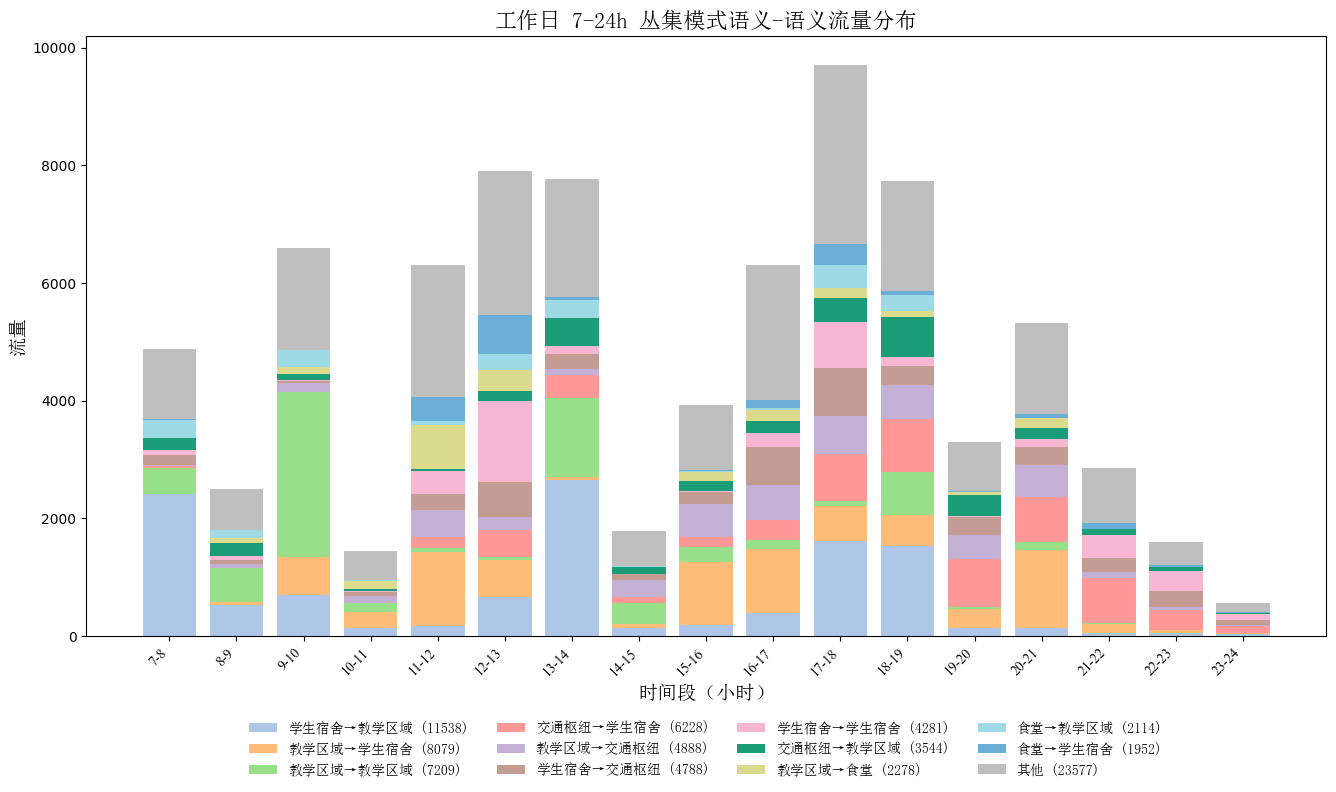

In [106]:
from matplotlib.font_manager import FontProperties

font_cn = FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")
font_en = FontProperties(fname=r"C:\Windows\Fonts\times.ttf")

fig = plot_top_od_stacked_bar_by_hour(
    folder_path=r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters",
    day_type="工作日",
    start_hour=7,
    end_hour=23,
    top_pct=1,
    max_od_labels=11,
    figsize=(16, 10),
    font_cn=font_cn,
    font_en=font_en
)

fig.savefig("01_cluster_pattern_7_23_workday.png", dpi=500)


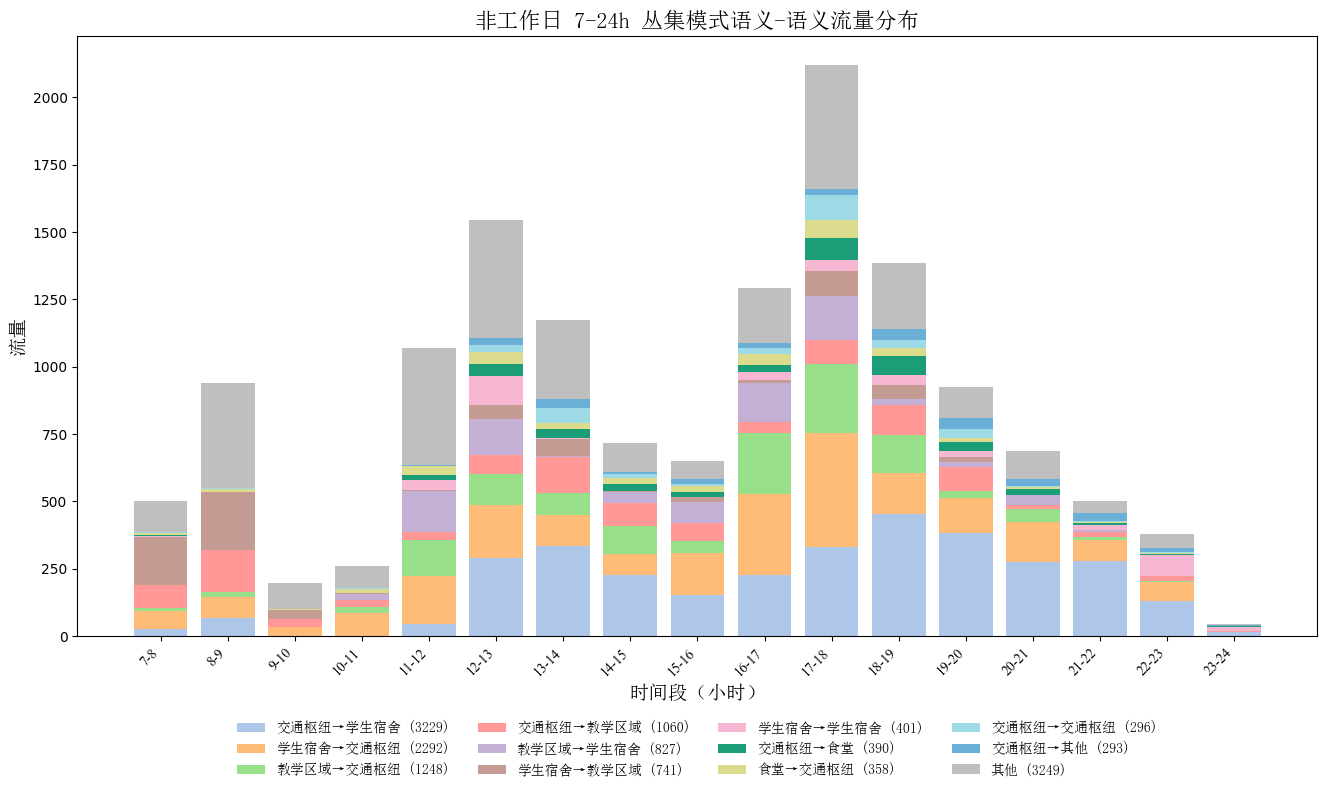

In [95]:

font_cn = FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")
font_en = FontProperties(fname=r"C:\Windows\Fonts\times.ttf")

fig = plot_top_od_stacked_bar_by_hour(
    folder_path=r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters",
    day_type="非工作日",
    start_hour=7,
    end_hour=23,
    top_pct=1,
    max_od_labels=11,
    figsize=(16, 10),
    font_cn=font_cn,
    font_en=font_en
)

fig.savefig("01_cluster_pattern_7_23_weekend.png", dpi=500)